# Introduction

In Q-leraning, we maintain a matrix to save all the action values. However, this does not work for continuous space, or a complex environment with huge action and state spaces. It is natural to consider replace the Q-table by a function. In other words, we use a function to approximate Q. This is the core idea of DQN (Deep-Q Network).

Notice that DQN may not be suitable for continuous action space, since we will do $\max Q$ for the value updates, which could be hard for an NN if the actions are not discrete. 

First we write out the update rulws for Q-learning: $$Q(s, a) \leftarrow Q(s, a) + \alpha (r + \gamma \max_{a'}Q(s', a')- Q(s, a))$$

# CartPole env
In the CartPole Env, there exists a cart, on top of which stands a pole. The agent is required to move the cart horizontally such to make the pole standing. If the pole tilts too much, or the cart moves too far from the initial place, or neither of the two happenes for 200 frames, the game ends. The state of the agent is a tuple of (cart_position, cart_velocity, pole_angle, pole_tip_velocity). We have 2 actions, 0 for left and 1 for right.

# DQN for CartPole env

Instead of learning a function $f: (s, a) \rightarrow Q$, we can simply set it to learn the action given the state, i.e. $f: s \rightarrow a$. 

Now an improtant question comes to us: how do we define the loss function?

It is simple to use an MSE loss between $Q_\omega(s, a)$ (the learnt action value) and the TD estimation $r + \gamma \max_{a'}Q(s', a')$, which theoretically should equal the actaul action values:

$$\omega^* = \arg \min_{\omega} \frac{1}{2N}\sum_{i=1}^N[Q_\omega(s_i, a_i) - (r + \gamma \max_{a'}Q_\omega(s'_i, a'))]^2$$

Now that we have the loss function, we have expand RL into its NN form. Since DQN use the same idea as of Q-learning, it is also off-policy. Therefore, we can banalnce exploration and exploitation by $\epsilon$-greedy, and collect the sampled data for later updates. 

Before we implement DQN, there are 2 modules we need to know that facilitates DQN training to be stable and eminent, namely experience replay and target network. 

## Experience replay

Consider a supervised learning task, where we sample 1 or a batch of data for 1 gradient update. With the training goes on, especially when we have multiple epochs, a certain data sample is used multiple times. The reason why we can do this is that in supervised learning, we have an important assumption: the i.i.d assumption that says, all the data in the training set are independent from an identical distrituion. This is also the reason why RL, involving temporal data, could be hard to train using supervised methods: because the temporal struction breaks the i.i.d assumption. 

Since we use an NN to estimate $Q$, we will need much more data to feed it so that the network is thoroughly trained. This is why we need experience replay. 

In experience replay, we maintain a replay-loading area, where you will find all the sampled 4-element tuples $(s, a, r, s')$. In the training of the Q-network, we randomly sample from the area. By doing so, the training data satisfies i.i.d assumption, and each data sample can be used multiple times to train the network. 

## Target Network
The target of DQN training is to let $Q_\omega(s, a)$ approach $(r + \gamma \max_{a'} Q_\omega(s', a'))$. Since the TD error contains the output of the network, and the output of the network is changing during updates, it is very likely to induce an unstable training. In order to solve this issue, we introduce the target network. 

The idea of the target network is to fix the Q network for loss calculation. Thus, we have 2 sets of Q-networks:
- the previous Q-network for update, responsible for $Q_\omega(s, a)$ in loss calculation
- the target Q-network for stable loss calculation, responsible for $\max_{a'}Q_{\omega^-} (s', a')$

Every $C$ step the target $Q_{\omega^-}$ will be synchronized to $Q_\omega$, while $Q_\omega$ is updated every step based on gradient updating. 

To sum up, DQN algorithm is:

- Init $Q_\omega(s, a)$
- Copy $Q_\omega(s, a)$ to $Q_{\omega^-}(s, a)$
- Init replay pool $R$
- for episode $e \leftarrow 1$ to $E$:
    - get init state $s_1$
    - for timestep $t \leftarrow 1$ to $T$:
        - use $\epsilon$-greedy to choose action $a_t$
        - take $a_t$ and get the response $r_t, s_{t+1}$
        - put $(s_t, a_t, r_t, s_{t+1})$ into $R$
        - if $R$ has enough data, sample $N$ data $\{(s_i, a_i, r_i, s_{i+1})\}_{i=1, ..., N}$ from $R$
        - for each sampled data from $R$, calculate target $y_i = r_i + \gamma \max_{a'} Q_{\omega^-}(s_{i+1}, a')$
        - minimize loss $L = \frac{1}{N} \sum_{i} (y_i - Q_\omega(s_t, a_t))^2$, then update $Q_\omega$
        - update $Q_{\omega^-}$
    - end for
- end for

In [ ]:
!pip list | grep numpy

numpy                   2.2.5


In [ ]:
import random
import numpy as np
np.bool8 = np.bool_
import gym
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
import copy

In [ ]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, terminated, truncated):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, terminated, truncated))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, terminated, truncated = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), terminated, truncated

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [ ]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [258]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device, final_epsilon=0.01, decay_rate=0.9):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)
        
        # make the two Q nets has the same init param
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device
        self.final_epsilon = final_epsilon
        self.decay_rate = decay_rate

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = torch.argmax(self.q_net(state), dim=1).numpy()[0]
        return action

    def update(self, transition_dict):
        # print(transition_dict.keys())
        # implement DQN
        states = torch.tensor(transition_dict["states"], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict["actions"], dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict["rewards"], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict["next_states"], dtype=torch.float).to(self.device)
        terminated = torch.tensor(transition_dict["terminated"], dtype=torch.float).to(self.device)
        truncated = torch.tensor(transition_dict["truncated"], dtype=torch.float).to(self.device)

        # print(f"states:{states}")
        # print(f"actions:{actions.squeeze()}")
        # print(f"rewards:{rewards.squeeze()}")
        # print(f"next_states:{next_states}")
        # print(f"terminated:{terminated.squeeze()}")
        # print(f"truncated:{truncated.squeeze()}")


        with torch.no_grad():
            res = self.target_q_net(next_states)
        max_q, _ = torch.max(res, dim=1)
        td_est = rewards.squeeze() + self.gamma * max_q * (1 - terminated).squeeze() * (1 - truncated).squeeze()
        q_values = self.q_net(states).gather(1, actions.long()).squeeze()
        dqn_loss = torch.mean(F.mse_loss(q_values, td_est)) # mean squared loss

        # print(f"max_q:{max_q}")
        # print(f"td_est:{td_est}")
        # print(f"q_values:{q_values}")
        # print(f"dqn_loss:{dqn_loss}")
        
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        # for name, param in self.q_net.named_parameters():
        #     if param.grad is None:
        #         print(f"[No Grad] {name}")
        #     else:
        #         print(f"[Has Grad] {name} | Mean grad: {param.grad.abs().mean().item():.6f}")

        # grad_norm = sum(p.grad.data.norm(2).item() ** 2 for p in self.q_net.parameters()) ** 0.5
        # print(f"Gradient norm: {grad_norm:.4f}")

        # update the target network if C steps passed
        self.epsilon = max(self.final_epsilon, self.epsilon * self.decay_rate)

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict()) 
        self.count += 1
        return dqn_loss.detach().item()

In [261]:
lr = 5e-4
num_episodes = 500
hidden_dim = 128
gamma = 0.95
epsilon = 0.9
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
loss_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()[0]
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                if truncated:
                    reward += 200
                elif terminated:
                    reward -= 100
                replay_buffer.add(state, action, reward, next_state, terminated, truncated)
                done = terminated or truncated
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_ter, b_tru = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'terminated': b_ter,
                        'truncated': b_tru
                    }
                    loss = agent.update(transition_dict)
                    loss_list.append(loss)

            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 50/50 [00:03<00:00, 13.95it/s, episode=500, return=400.000]


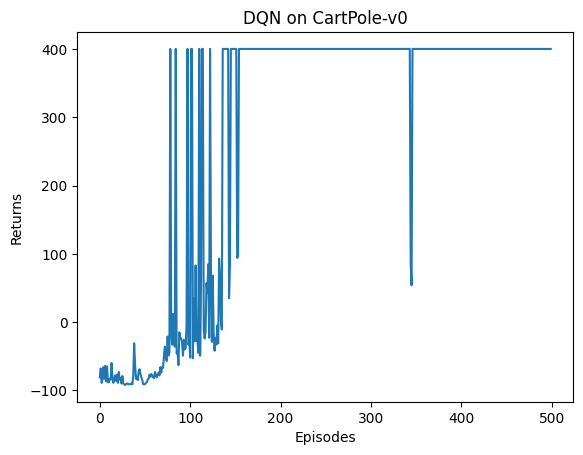

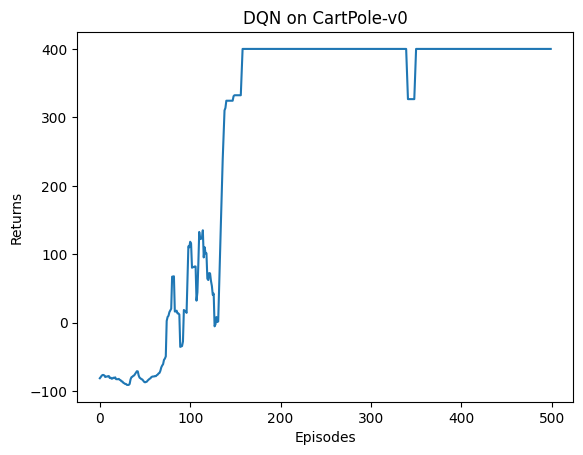

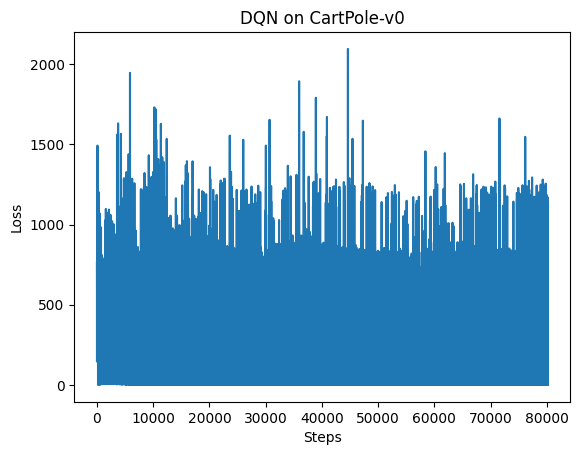

In [262]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

plt.plot(loss_list)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('DQN on {}'.format(env_name))
plt.show()

# DQN with image inputs
A convolution layer captures information from image. So we can add it to the Q network to enable the agent learn directly from envrionments like video games. Usually, we use a group of adjacent frames as the input to better capture the state patterns. 

In [263]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)